# National Water Model pull and plot
*J. Michelle Hu  
University of Utah  
July 2024*  
---

Acquisition code pulled from https://github.com/CIROH-UVM/training-data-workflows-101/blob/main/05-ExpandingTheWorkflow_Acquire.ipynb

In [1]:
from s3fs import S3FileSystem, S3Map
import xarray as xr
import pyproj
import geopandas as gpd
import os
import numpy as np
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc
import matplotlib.pyplot as plt

In [2]:
# For the NWM env follow these instructions
# https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
pyprojdatadir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-hb784bbd_0/share/proj'
pyproj.datadir.set_data_dir(pyprojdatadir)

In [3]:
def fn_list(thisDir, fn_pattern, verbose=False):
    """Match and sort filenames based on a regex pattern in specified directory

    Parameters
    -------------
    thisDir: str
        directory path to search
    fn_pattern: str
        regex pattern to match files
    verbose: boolean
        print filenames
    
    Returns
    -------------
    fns: list
        list of filenames matched and sorted
    """
    import glob
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern):
        fns.append(f)
    fns.sort()
    if verbose: print(fns)
    return fns

## Load SNOTEL site location data
Add in the snotel location code here so there's no need to read/write to file  
TODO: Need to keep site_name associated with extracted ds for plotting and in metadata of extracted DS

In [4]:
# snotel site json
site_json = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'

basin = 'blue'
wy = 2021
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys'
poly_fn = fn_list(poly_dir, f'*{basin}*shp')[0]
poly_fn

'/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys/blue_river_basin_outline_HUC10dissolved_32613.shp'

In [5]:
site_gdf = proc.locate_snotel_in_poly(poly_fn, site_json)
site_gdf

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num,geometry
155,SNTL,CO,Copper Mountain (415),None,1978-October,39.49,-106.17,10523,Summit,West Tenmile Creek (140100020302),415,POINT (399388.787 4371808.031)
167,SNTL,CO,Fremont Pass (485),None,1979-October,39.38,-106.20,11326,Summit,Upper Tenmile Creek (140100020301),485,POINT (396646.502 4359633.712)
170,SNTL,CO,Grizzly Peak (505),None,1979-October,39.65,-105.87,11139,Summit,North Fork Snake River (140100020201),505,POINT (425358.761 4389273.436)


In [6]:
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/NWM_datasets_proj4.txt"
# This is the correct one (derived from esri_pe_string)
# Don't use the proj4 string from the NWM ds.attrs['proj4'], it appears to be wrong
# proj4 = '+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'
# Write
# with open(proj_fn, "w") as text_file:
#     text_file.write(proj4)

# Read
with open(proj_fn, "r") as f:
    proj4 = f.read()
proj4

'+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'

In [7]:
# Change the crs of the site_gdf to the NWM crs
site_gdf.set_crs('epsg:32613', inplace=True, allow_override=True)
site_gdf = site_gdf.to_crs(crs=proj4)
site_gdf.crs

<Projected CRS: +proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [8]:
%%time
basin_nwm_ds = proc.get_nwm_retrospective_LDAS(site_gdf, start=f'{wy-1}-10-01', end=f'{wy}-09-30', var='SNOWH')

CPU times: user 2.59 s, sys: 341 ms, total: 2.93 s
Wall time: 9.98 s


CPU times: user 3.15 s, sys: 2.4 s, total: 5.55 s
Wall time: 15.6 s


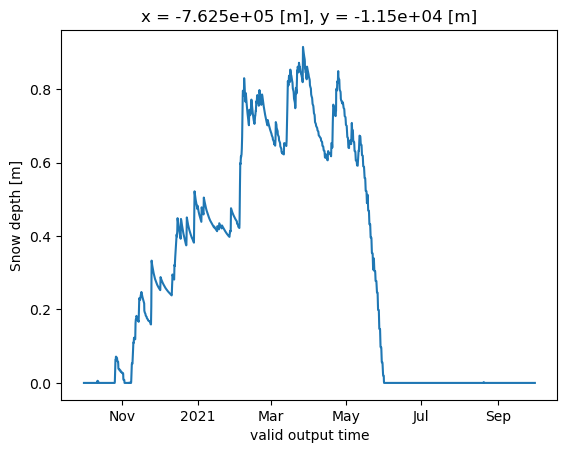

In [9]:
%%time
basin_nwm_ds[0].plot()

CPU times: user 10.8 s, sys: 7.81 s, total: 18.6 s
Wall time: 57.7 s


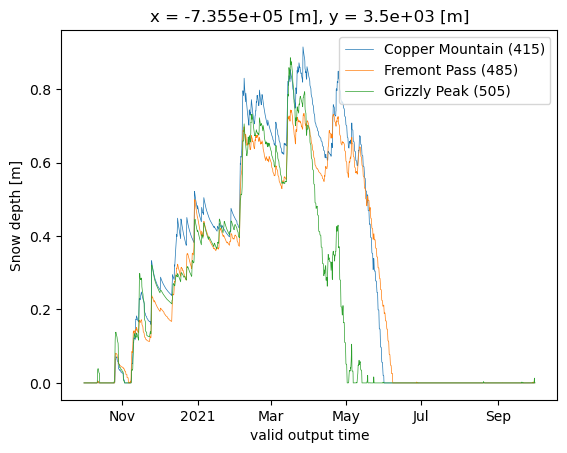

In [10]:
%%time
fig, ax = plt.subplots(1)
for jdx, ds in enumerate(basin_nwm_ds):
    ds.plot(ax=ax, label=site_gdf['site_name'].iloc[jdx], linewidth=0.5)
plt.legend();

In [11]:
ds

<xarray.DataArray 'SNOWH' (time: 2920)> Size: 23kB
[2920 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 23kB 2020-10-01 ... 2021-09-30T21:00:00
    x        float64 8B -7.355e+05
    y        float64 8B 3.5e+03
Attributes:
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       Snow depth
    units:           m
    valid_range:     [0, 1000000]

In [12]:
for ds in basin_nwm_ds:
    print(len(ds['time']))

2920
2920
2920


In [13]:
import pandas as pd

In [14]:
%%time
# Turn it into a dict?
nwm_snowh_dict = dict()
for jdx, ds in enumerate(basin_nwm_ds):
    nwm_snowh_dict[site_gdf['site_name'].values[jdx]] = ds.values

nwm_snowh_dict

CPU times: user 11 s, sys: 7.61 s, total: 18.6 s
Wall time: 50 s


{'Copper Mountain (415)': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.99999975e-05, 0.00000000e+00]),
 'Fremont Pass (485)': array([0.    , 0.    , 0.    , ..., 0.0015, 0.0006, 0.0002]),
 'Grizzly Peak (505)': array([0.    , 0.    , 0.    , ..., 0.0111, 0.0008, 0.0003])}

In [15]:
# Turn it into a dataframe
df = pd.DataFrame(nwm_snowh_dict, index=ds['time'].values)
df

,Copper Mountain (415),Fremont Pass (485),Grizzly Peak (505)
2020-10-01 00:00:00,0.0000,0.0000,0.0000
2020-10-01 03:00:00,0.0000,0.0000,0.0000
2020-10-01 06:00:00,0.0000,0.0000,0.0000
2020-10-01 09:00:00,0.0000,0.0000,0.0000
2020-10-01 12:00:00,0.0000,0.0000,0.0000
...,...,...,...
2021-09-30 09:00:00,0.0000,0.0000,0.0090
2021-09-30 12:00:00,0.0000,0.0010,0.0132
2021-09-30 15:00:00,0.0000,0.0015,0.0111
2021-09-30 18:00:00,0.0001,0.0006,0.0008


<Axes: >

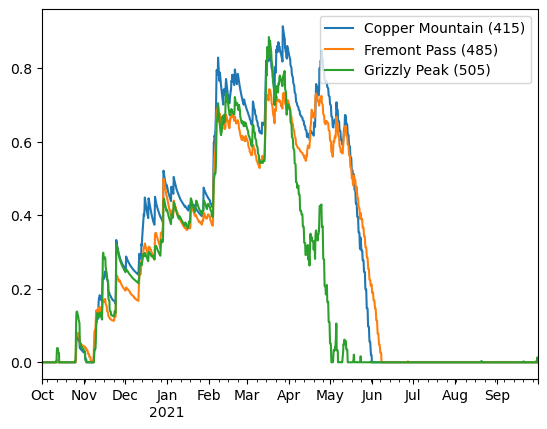

In [16]:
df.plot()

In [17]:
# Save the the dataframe as csv for easy access later
nwm_basin_dir = f'/uufs/chpc.utah.edu/common/home/skiles-group3/NWM/{basin}'
nwm_basin_dir
if not os.path.exists(nwm_basin_dir):
    os.makedirs(nwm_basin_dir)
outname = f'{nwm_basin_dir}/{basin}_nwm_snotel_SNOWH_wy{wy}.csv'
if not os.path.exists(outname):
    df.to_csv(outname)
print(outname)

/uufs/chpc.utah.edu/common/home/skiles-group3/NWM/blue/blue_nwm_snotel_SNOWH_wy2021.csv


In [18]:
site_gdf['site_name']

155    Copper Mountain (415)
167       Fremont Pass (485)
170       Grizzly Peak (505)
Name: site_name, dtype: object

In [19]:
len(site_gdf)

3

## Spatial: now do the same for the model domain

In [20]:
bucket = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr'
fs = S3FileSystem(anon=True)
ds = xr.open_dataset(S3Map(f"{bucket}/ldasout.zarr", s3=fs), engine='zarr')

In [21]:
ds

<xarray.Dataset> Size: 510TB
Dimensions:   (time: 128568, y: 3840, x: 4608, vis_nir: 2, soil_layers_stag: 4)
Coordinates:
  * time      (time) datetime64[ns] 1MB 1979-02-01T03:00:00 ... 2023-02-01
  * x         (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y         (y) float64 31kB -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Dimensions without coordinates: vis_nir, soil_layers_stag
Data variables: (12/21)
    ACCET     (time, y, x) float64 18TB ...
    ACSNOM    (time, y, x) float64 18TB ...
    ALBEDO    (time, y, x) float64 18TB ...
    ALBSND    (time, y, vis_nir, x) float64 36TB ...
    ALBSNI    (time, y, vis_nir, x) float64 36TB ...
    COSZ      (time, y, x) float64 18TB ...
    ...        ...
    SNOWH     (time, y, x) float64 18TB ...
    SOIL_M    (time, y, soil_layers_stag, x) float64 73TB ...
    SOIL_W    (time, y, soil_layers_stag, x) float64 73TB ...
    TRAD      (time, y, x) float64 18TB ...
    UGDRNOFF  (time, y, x) float64 18TB ...
    crs       |S1 1B ...
Attributes:
    Conventions:          CF-1.6
    GDAL_DataType:        Generic
    NCO:                  netCDF Operators version 5.1.4 (Homepage = http://n...
    TITLE:                OUTPUT FROM WRF-Hydro v5.3.0-alpha1
    code_version:         v5.3.0-alpha1
    history:              Thu Sep 28 08:10:06 2023: ncatted -O -a missing_val...
    model_configuration:  retrospective
    model_output_type:    land
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

In [22]:
ds.attrs['proj4']

'+proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=40.0 +lon_0=-97.0 +x_0=0 +y_0=0 +k_0=1.0 +nadgrids=@null +wktext  +no_defs'

In [23]:
proj4

'+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'

In [24]:
type(ds)

xarray.core.dataset.Dataset

In [25]:
ds.x.min(), ds.x.max()

(<xarray.DataArray 'x' ()> Size: 8B
 array(-2303499.25),
 <xarray.DataArray 'x' ()> Size: 8B
 array(2303500.75))

In [26]:
ds. y.min(), ds.y.max()

(<xarray.DataArray 'y' ()> Size: 8B
 array(-1919500.375),
 <xarray.DataArray 'y' ()> Size: 8B
 array(1919499.625))

In [27]:
# # Define a bounding box by lat lon for the model domain in coordinates
# #Upper Yampa  -107.707˚, 39.967˚, -106.663˚, 40.901˚
# #Lower Yampa  -109.044˚, 40.105 ˚, -107.525˚, 40.772˚
# # Lower Left, Lower Right, Upper Right, Upper Left, Lower Left to close the polygon
# # yampa_latlon = [(-109.044, 39.967), (-106.663, 39.967), (-106.663, 40.901), (-109.044, 40.901), (-109.044, 39.967)]
# # yampa_latlon

# latlon = [(), (), (), ())]

In [28]:
# from shapely.geometry import Polygon
# # Turn the lat lon box into a shapely polygon
# yampa_poly = Polygon(yampa_latlon)
# yampa_poly

In [29]:
# # Turn the Polygon into a GeoDataFrame
# yampa_gdf = gpd.GeoDataFrame(geometry=[yampa_poly])
# yampa_gdf

In [30]:
# # Change the crs of the site_gdf to the NWM crs
# yampa_gdf.set_crs('epsg:4326', inplace=True, allow_override=True)
# yampa_gdf = yampa_gdf.to_crs(crs=proj4)
# yampa_gdf.crs

In [31]:
# # Convert to the NWM proj4
# yampa_nwmproj = yampa_gdf.to_crs(crs=proj4)

In [32]:
# yampa_nwmproj.geometry

In [33]:
# yampa_nwmproj.bounds

In [35]:
poly_gdf = gpd.read_file(poly_fn)
poly_gdf

,fid,objectid,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,states,huc10,name,hutype,humod,globalid,shape_Leng,shape_Area,geometry
0,10748.0,11045.0,{C8B84365-00DB-4683-992A-7683BB37F907},{45CC2D32-AFE4-44CA-BD9F-1A3A80B4BD14},None,None,None,2017/10/24 15:47:42.000,None,78906.43,319.32,CO,1401000201,Headwaters Blue River,S,None,{210F9A16-E29C-11E2-8094-0021280458E6},0.992797,0.033424,"POLYGON ((425382.322 4374760.238, 425397.138 4..."


In [36]:
epsg = 'epsg:32613'
poly_gdf.set_crs(epsg, inplace=True, allow_override=True)
poly_gdf.geometry

0    POLYGON ((425382.322 4374760.238, 425397.138 4...
Name: geometry, dtype: geometry

In [37]:
poly_gdf = poly_gdf.to_crs(crs=proj4)
poly_gdf.geometry

0    POLYGON ((-737056.157 -11023.941, -737048.243 ...
Name: geometry, dtype: geometry

In [38]:
poly_gdf.bounds

,minx,miny,maxx,maxy
0,-769761.716052,-26750.061232,-728380.589127,6041.585138


In [39]:
# Crop the dataset to the yampa polygon extent
cropped_ds = ds.sel(x=slice(poly_gdf.bounds.minx.values[0], poly_gdf.bounds.maxx.values[0]), 
                    y=slice(poly_gdf.bounds.miny.values[0], poly_gdf.bounds.maxy.values[0]))
cropped_ds

<xarray.Dataset> Size: 40GB
Dimensions:   (time: 128568, y: 33, x: 42, vis_nir: 2, soil_layers_stag: 4)
Coordinates:
  * time      (time) datetime64[ns] 1MB 1979-02-01T03:00:00 ... 2023-02-01
  * x         (x) float64 336B -7.695e+05 -7.685e+05 ... -7.295e+05 -7.285e+05
  * y         (y) float64 264B -2.65e+04 -2.55e+04 -2.45e+04 ... 4.5e+03 5.5e+03
Dimensions without coordinates: vis_nir, soil_layers_stag
Data variables: (12/21)
    ACCET     (time, y, x) float64 1GB ...
    ACSNOM    (time, y, x) float64 1GB ...
    ALBEDO    (time, y, x) float64 1GB ...
    ALBSND    (time, y, vis_nir, x) float64 3GB ...
    ALBSNI    (time, y, vis_nir, x) float64 3GB ...
    COSZ      (time, y, x) float64 1GB ...
    ...        ...
    SNOWH     (time, y, x) float64 1GB ...
    SOIL_M    (time, y, soil_layers_stag, x) float64 6GB ...
    SOIL_W    (time, y, soil_layers_stag, x) float64 6GB ...
    TRAD      (time, y, x) float64 1GB ...
    UGDRNOFF  (time, y, x) float64 1GB ...
    crs       |S1 1B ...
Attributes:
    Conventions:          CF-1.6
    GDAL_DataType:        Generic
    NCO:                  netCDF Operators version 5.1.4 (Homepage = http://n...
    TITLE:                OUTPUT FROM WRF-Hydro v5.3.0-alpha1
    code_version:         v5.3.0-alpha1
    history:              Thu Sep 28 08:10:06 2023: ncatted -O -a missing_val...
    model_configuration:  retrospective
    model_output_type:    land
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

In [40]:
var = 'SNOWH'
print(cropped_ds[var])
print(f'Variable size: {cropped_ds[var].nbytes/1e9:.1f} GB')

<xarray.DataArray 'SNOWH' (time: 128568, y: 33, x: 42)> Size: 1GB
[178195248 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1MB 1979-02-01T03:00:00 ... 2023-02-01
  * x        (x) float64 336B -7.695e+05 -7.685e+05 ... -7.295e+05 -7.285e+05
  * y        (y) float64 264B -2.65e+04 -2.55e+04 -2.45e+04 ... 4.5e+03 5.5e+03
Attributes:
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       Snow depth
    units:           m
    valid_range:     [0, 1000000]
Variable size: 1.4 GB


In [41]:
cropped_ds[var].time

<xarray.DataArray 'time' (time: 128568)> Size: 1MB
array(['1979-02-01T03:00:00.000000000', '1979-02-01T06:00:00.000000000',
       '1979-02-01T09:00:00.000000000', ..., '2023-01-31T18:00:00.000000000',
       '2023-01-31T21:00:00.000000000', '2023-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1MB 1979-02-01T03:00:00 ... 2023-02-01
Attributes:
    long_name:      valid output time
    standard_name:  time
    valid_max:      4863060
    valid_min:      4778100

In [59]:
# Based on validation timesteps, select a time slice
# Blue River ASO dates
dt = '2019-04-19'
# dt = '2019-06-24'

In [60]:
# convert to datetime object
dt = np.datetime64(dt)

In [61]:
cropped_ds[var].sel(time=dt)

<xarray.DataArray 'SNOWH' (y: 33, x: 42)> Size: 11kB
[1386 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 8B 2019-04-19
  * x        (x) float64 336B -7.695e+05 -7.685e+05 ... -7.295e+05 -7.285e+05
  * y        (y) float64 264B -2.65e+04 -2.55e+04 -2.45e+04 ... 4.5e+03 5.5e+03
Attributes:
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       Snow depth
    units:           m
    valid_range:     [0, 1000000]

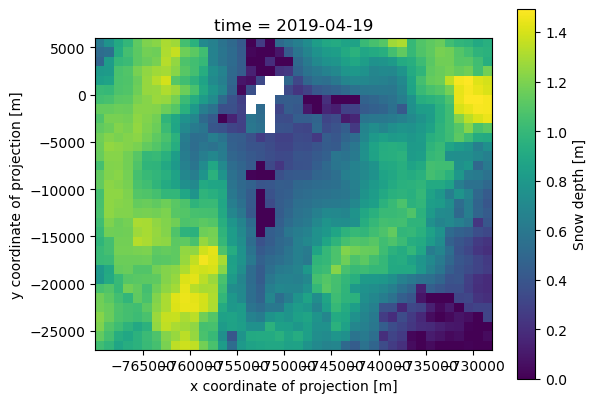

In [62]:
# Plot the snow depth as an image, select a time slice
fig, ax = plt.subplots()
cropped_ds[var].sel(time=dt).plot.imshow(ax=ax)
ax.set_aspect('equal')

In [63]:
''.join(str(dt).split('-'))

'20190419'

In [64]:
if pd.to_datetime(dt).month < 9:
    wy = pd.to_datetime(dt).year
else:
    wy = pd.to_datetime(dt).year - 1
wy

2019

In [65]:
# find isnobal output and compare directly
# snobal_dir = f"/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal/wy2020/yampa_basin_100m/run{''.join(str(dt).split('-'))}"
model_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
snobal_dir = fn_list(model_dir, f"*{basin}*isnobal/wy{wy}/{basin}*_100m/run{''.join(str(dt).split('-'))}")[0]
snobal_dir

'/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/blue_river_100m_isnobal/wy2019/blue_river_basin_100m/run20190419'

In [66]:
# Read in snow depth and plot
depth_fn = proc.fn_list(snobal_dir, "*snow.nc")[0]
depth_fn

'/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/blue_river_100m_isnobal/wy2019/blue_river_basin_100m/run20190419/snow.nc'

In [67]:
depth = np.squeeze(xr.open_mfdataset(depth_fn, decode_coords="all")['thickness'])
depth.rio.write_crs('epsg:32613', inplace=True)
depth

<xarray.DataArray 'thickness' (y: 360, x: 428)> Size: 616kB
dask.array<getitem, shape=(360, 428), dtype=float32, chunksize=(360, 428), chunktype=numpy.ndarray>
Coordinates:
    time        datetime64[ns] 8B 2019-04-19T22:00:00.002244608
  * y           (y) float32 1kB 4.392e+06 4.392e+06 ... 4.357e+06 4.356e+06
  * x           (x) float32 2kB 3.912e+05 3.913e+05 ... 4.338e+05 4.339e+05
    projection  int64 8B 0
Attributes:
    units:        m
    description:  Predicted thickness of the snowcover

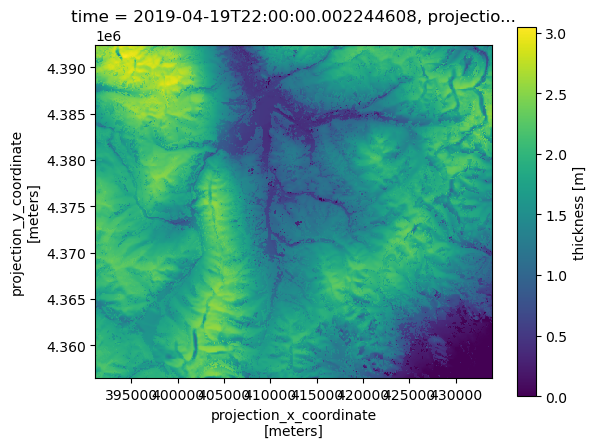

In [68]:
# Plot the iSnobal snow depth 
fig, ax = plt.subplots()
depth.plot.imshow(ax=ax)
ax.set_aspect('equal')

In [69]:
depth.shape

(360, 428)

In [70]:
nwm_depth = cropped_ds[var].sel(time=dt)
nwm_depth.shape

(33, 42)

In [71]:
nwm_depth.rio.write_crs(input_crs=proj4, inplace=True)

<xarray.DataArray 'SNOWH' (y: 33, x: 42)> Size: 11kB
[1386 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 8B 2019-04-19
  * x        (x) float64 336B -7.695e+05 -7.685e+05 ... -7.295e+05 -7.285e+05
  * y        (y) float64 264B -2.65e+04 -2.55e+04 -2.45e+04 ... 4.5e+03 5.5e+03
    crs      int64 8B 0
Attributes:
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    long_name:       Snow depth
    units:           m
    valid_range:     [0, 1000000]

In [72]:
# Warp to the same extent and projection
depth_reproj = depth.rio.reproject_match(nwm_depth)
depth_reproj.rio.crs

CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [73]:
depth_reproj.shape

(33, 42)

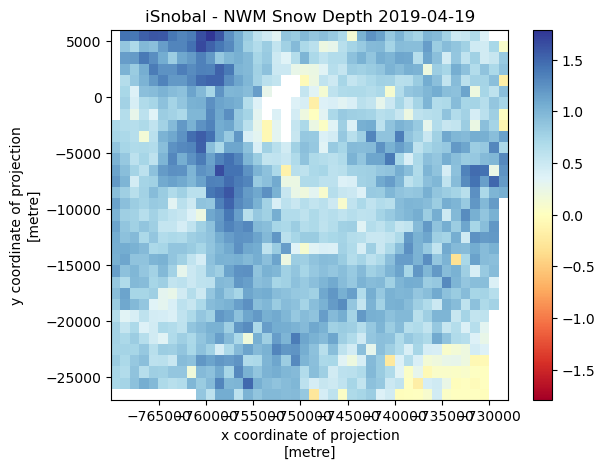

In [74]:
# Plot the difference
(depth_reproj - nwm_depth).plot.imshow(cmap='RdYlBu')
ax = plt.gca()
ax.set_title(f'iSnobal - NWM Snow Depth {dt}');